# EDA and LDA model testing (single document corpus, copy/pasted article text or html) for 'debiaser' data product
#### Sagar Setru, September 16th, 2020

## Brief description using CoNVO framework

### Context

Some people are eager to get news from outside of their echo chamber. However, they do not know where to go outside of their echo chambers, and may also have some activation energy when it comes to seeking information from other sources. In the meantime, most newsfeeds only push you content that you agree with. You end up in an echo chamber, but may not have ever wanted to be in one in the first place.

### Need

A way to find news articles from different yet reliable media sources.

### Vision

Debiaser, a data product (maybe Chrome plug-in?) that will recommend news articles similar in topic to the one currently being read, but from several pre-curated and reliable news media organizations across the political spectrum, for example, following the "media bias chart" here https://www.adfontesmedia.com/ or the "media bias ratings" here: https://www.allsides.com/media-bias/media-bias-ratings. The app will determine the main topics of the text of a news article, and then show links to similar articles from other news organizations.

The product will generate topics for a given document via latent Dirichlet allocation (LDA) and then search news websites for the topic words generated.

Caveats: Many of these articles may be behind paywalls. News aggregators already basically do this. How different is this than just searching Google using the title of an article?

### Outcome

People who are motivated to engage in content outside of their echo chambers have a tool that enables them to quickly find news similar to what they are currently reading, but from a variety of news organizations.

# EDA, LDA testing

In [1]:
# make sure I'm in the right environment (should be 'debiaser')
import os

print('Conda environment:')
print(os.environ['CONDA_DEFAULT_ENV'])

Conda environment:
debiaser


In [2]:
# import base packages

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# import text processing and NLP specific packages

# for generating LDA models
import gensim
from gensim.corpora import Dictionary

# for preprocessing documents
from gensim.parsing.preprocessing import preprocess_documents

# to break articles up into sentences (currently not in use)
from nltk import tokenize

# for doing lemmatizing
from nltk.stem import WordNetLemmatizer, SnowballStemmer

# for counting frequency of words
from collections import defaultdict

import string


# for processing lda topic output
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_numeric

In [63]:
import spacy
nlp  = spacy.load('en_core_web_sm')

In [4]:
# for parsing html code

from bs4 import BeautifulSoup
import urllib.request,sys,time

In [5]:
def load_stop_words_csv_to_list(full_file_name):
    """fxn that loads stop words list downloaded from git repo called 'news-stopwords'"""
    
    stop_words = pd.read_csv(full_file_name)

    stop_words = stop_words['term']

    stop_words = [word for word in stop_words]
    
    return stop_words

In [6]:
def get_simple_corpus_dictionary_bow(texts,word_frequency_threshold):
    """fxn returns corpus, proc. dict, bag of words"""
    
    # Count word frequencies
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1

    # Only keep words that appear more than set frequency, to produce the corpus
    processed_corpus = [[token for token in text if frequency[token] > word_frequency_threshold] for text in texts]
    
    # generate a dictionary via gensim
    processed_dictionary = Dictionary(processed_corpus)
    
    # generate bag of words of the corpus
    bow_corpus = [processed_dictionary.doc2bow(text) for text in processed_corpus]
    
    return processed_corpus, processed_dictionary, bow_corpus

In [7]:
def sort_topics_mean_frequency(topics,topics_mean_probs_dict,topics_std_probs_dict,topics_frequency_dict):
    """fxn returns topics sorted by their mean probability and frequency. also returns std dev of prob"""
    
    # empty dict for topics
    x_topics = []
    
    # to store mean probs
    y_means = np.zeros((len(topics_mean_probs_dict)))
    
    # to store std dev probs
    y_std = np.zeros((len(topics_std_probs_dict)))
    
    # to store frequency of topic
    y_frequencies = np.zeros((len(topics_frequency_dict)))

    # measure mean probs
    counter = -1
    for topics, mean_prob in topics_mean_probs_dict.items():
        counter += 1
        x_topics.append(topics)
        y_means[counter] = mean_prob

    # measure std dev probs
    counter2 = -1
    for topics, frequency in topics_frequency_dict.items():
        counter2 += 1
        y_frequencies[counter2] = frequency

    # measure frequency topic shows up
    counter3 = -1
    for topics, std in topics_std_probs_dict.items():
        counter3 += 1
        y_std[counter3] = std

    # sort by mean and frequency

    zipped_mean = zip(y_means, x_topics)
    sorted_zipped_mean = sorted(zipped_mean)
    y_means_sorted = [element1 for element1,element2 in sorted_zipped_mean]
    y_means_sorted = y_means_sorted[::-1]
    x_topics_means = [element2 for element1,element2 in sorted_zipped_mean]
    x_topics_means = x_topics_means[::-1]

    zipped_mean_std = zip(y_means,y_std)
    sorted_zipped_mean_std = sorted(zipped_mean_std)
    y_std_sorted = [element2 for element1,element2 in sorted_zipped_mean_std]
    y_std_sorted = y_std_sorted[::-1]

    zipped_freq = zip(y_frequencies,x_topics)
    sorted_zipped_freq = sorted(zipped_freq)
    y_freq_sorted = [element1 for (element1,element2) in sorted_zipped_freq]
    y_freq_sorted = y_freq_sorted[::-1]
    x_topics_freq = [element2 for element1,element2 in sorted_zipped_freq]
    x_topics_freq = x_topics_freq[::-1]
    
    return x_topics_means, y_means_sorted, y_std_sorted, x_topics_freq, y_freq_sorted

In [73]:
def lemmatize(raw_texts,nlp):

    'Function that lemmatizes text'

    out_text = []
    
    for text in raw_texts:
        doc = nlp(text)


        #Remove stopwords and lemmatize
        tokens = [token.lemma_ for token in doc]
        
        out_text.append(tokens)
    
    return out_text

In [72]:
test = lemmatize(article_text,nlp)
print(test)

[['Hurricane', 'Sally', 'unleash', 'flooding', 'along', 'the', 'Gulf', 'Coast', 'by', 'JAY', 'REEVES', 'ANGIE', 'WANG', 'and', 'JEFF', 'MARTIN', '6', 'minute', 'ago', ' ', 'PENSACOLA', 'Fla', 'AP', '  ', 'Hurricane', 'Sally', 'lumber', 'ashore', 'near', 'the', 'Florida', 'Alabama', 'line', 'Wednesday', 'with', '105', 'mph', '165', 'wind', 'and', 'rain', 'measure', 'in', 'foot', 'not', 'inch', 'swamping', 'home', 'and', 'trap', 'people', 'in', 'high', 'water', 'as', '-PRON-', 'creep', 'inland', 'for', 'what', 'could', 'be', 'a', 'long', 'slow', 'and', 'disastrous', 'drenching', 'across', 'the', 'Deep', 'south'], ['move', 'at', 'an', 'agonizing', '3', 'mph', 'or', 'about', 'as', 'fast', 'as', 'a', 'person', 'can', 'walk', 'the', 'storm', 'make', 'landfall', 'at', '445', 'be', 'close', 'to', 'Gulf', 'Shores', 'Alabama', 'batter', 'the', 'metropolitan', 'area', 'of', 'Mobile', 'Alabama', 'and', 'Pensacola', 'Florida', 'which', 'have', 'a', 'combine', 'population', 'of', 'almost', '1', 'mil

In [8]:
# get list of manually made text files of articles

full_path = '/Users/sagarsetru/Documents/post PhD positions search/insightDataScience/project/debiaser/article_text_files/'

full_file_names = [
full_path+'ap_hurricane_sally_unleashes_20200916.txt',
full_path+'cnn_big_ten_backtracks_20200916.txt',
full_path+'nyt_on_the_fire_line_20200915.txt',
full_path+'foxnews_snake_face_mask_20200916_v2.txt',
'/Users/sagarsetru/Documents/post PhD positions search/insightDataScience/project/debiaser/article_html_files/U.S. Stocks Lower as Fed Outlook Rattles Investors - WSJ.html'
]

In [9]:
# choose list of stop words

# choose whether 1k, 10k, 100k, or nltk
which_stop_words = '1k'
# which_stop_words = '10k'
# which_stop_words = '100k'
# which_stop_words = 'nltk'

stop_words_path = '/Users/sagarsetru/Documents/post PhD positions search/insightDataScience/project/debiaser/stop_words_db/news-stopwords-master/'


if which_stop_words == '1k':
    
    # doing 1k words list
    stop_words_file_name = 'sw1k.csv'
    
    # make full file name
    stop_words_full_file_name = stop_words_path+stop_words_file_name
    
    # get list of stop words
    stop_words = load_stop_words_csv_to_list(stop_words_full_file_name)
    
elif which_stop_words == '10k':
    
    # doing 10k words list
    stop_words_file_name = 'sw10k.csv'

    # make full file name
    stop_words_full_file_name = stop_words_path+stop_words_file_name
    
    # get list of stop words
    stop_words = load_stop_words_csv_to_list(stop_words_full_file_name)

elif which_stop_words == '100k':
    
    # doing 100k
    stop_words_file_name = 'sw100k.csv'  
    
    # get full file name
    stop_words_full_file_name = stop_words_path+stop_words_file_name
    
    # get list of stop words
    stop_words = load_stop_words_csv_to_list(stop_words_full_file_name)


elif which_stop_words == 'nltk':
    # import from nltk
    from nltk.corpus import stopwords
    
    stop_words = stopwords.words('english')
    
else:
    print('Select proper variable name for "which_stop_words"')
    
# adding custom words
stop_words.append('said')
stop_words.append('youre')

ap_hurricane_sally_unleashes_20200916.txt
.txt


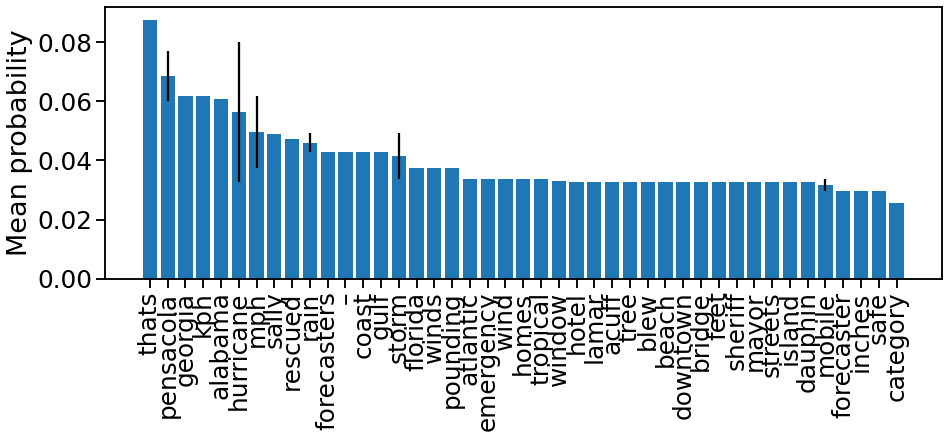

<Figure size 432x288 with 0 Axes>

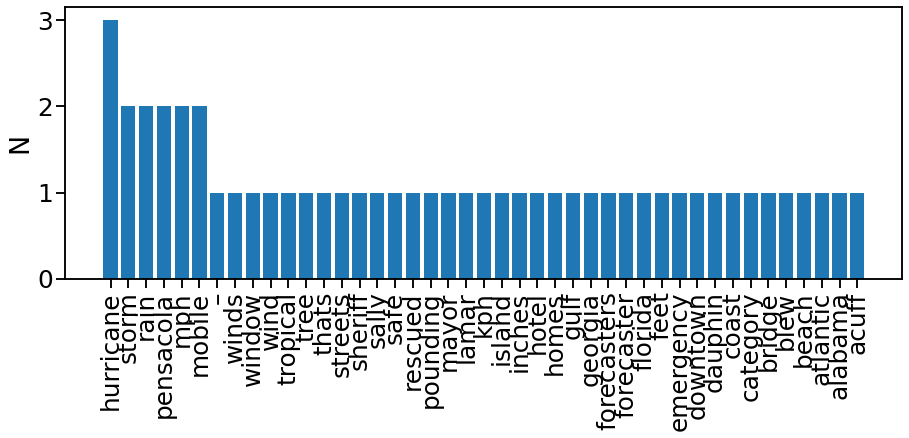

cnn_big_ten_backtracks_20200916.txt
.txt


<Figure size 432x288 with 0 Axes>

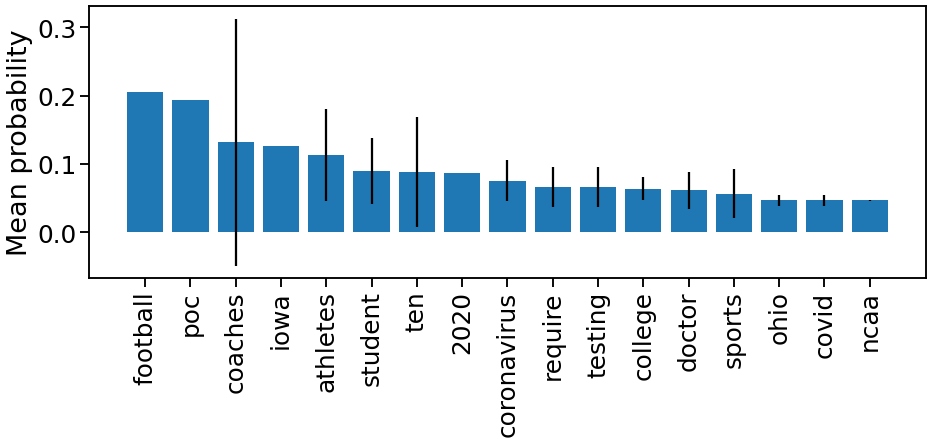

<Figure size 432x288 with 0 Axes>

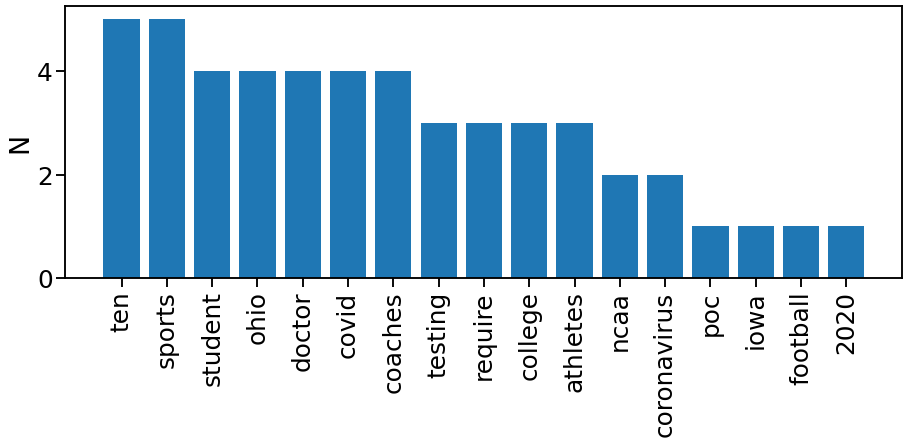

nyt_on_the_fire_line_20200915.txt
.txt


<Figure size 432x288 with 0 Axes>

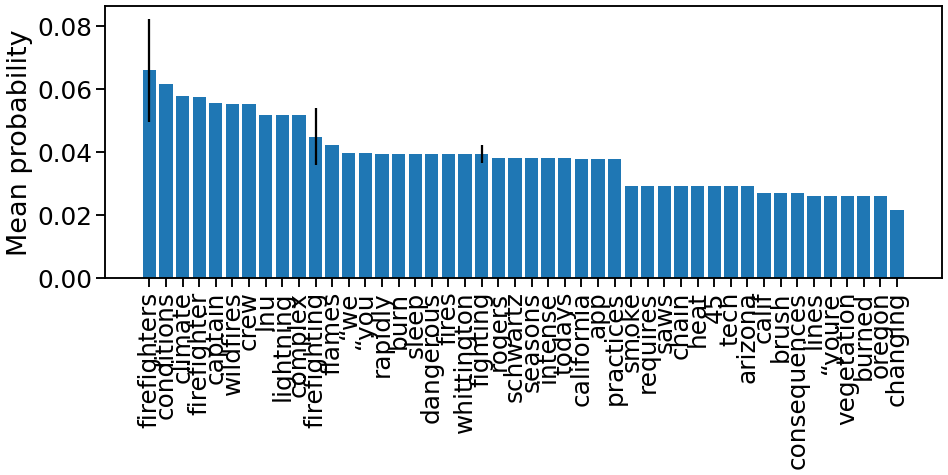

<Figure size 432x288 with 0 Axes>

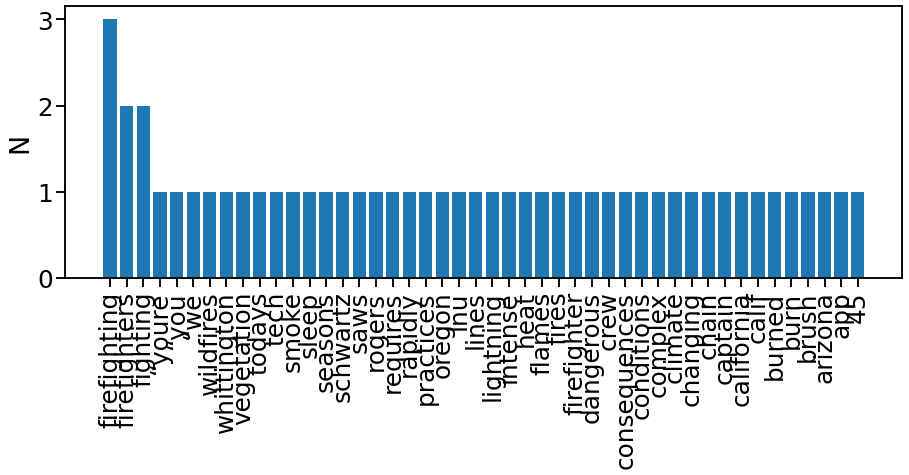

foxnews_snake_face_mask_20200916_v2.txt
.txt


<Figure size 432x288 with 0 Axes>

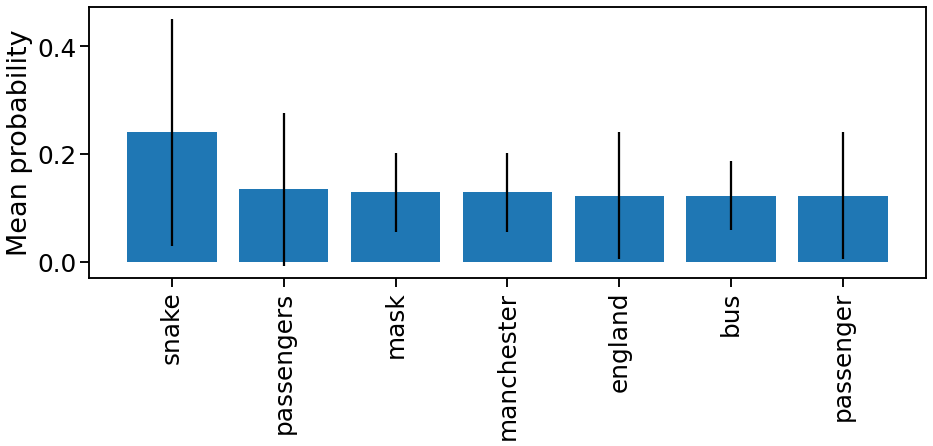

<Figure size 432x288 with 0 Axes>

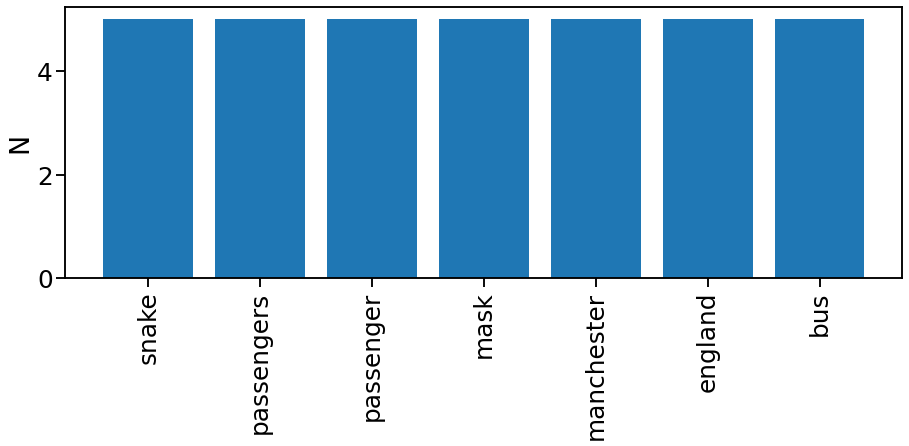

U.S. Stocks Lower as Fed Outlook Rattles Investors - WSJ.html
.html
The Wall Street Journal
 


<Figure size 432x288 with 0 Axes>

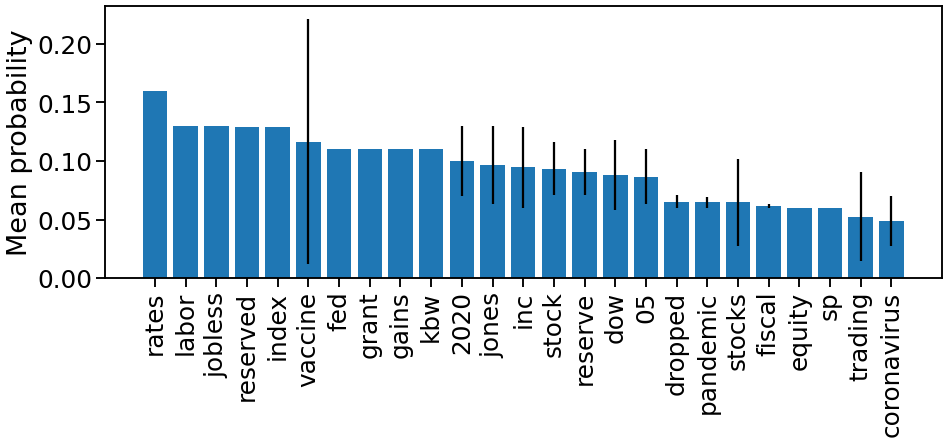

<Figure size 432x288 with 0 Axes>

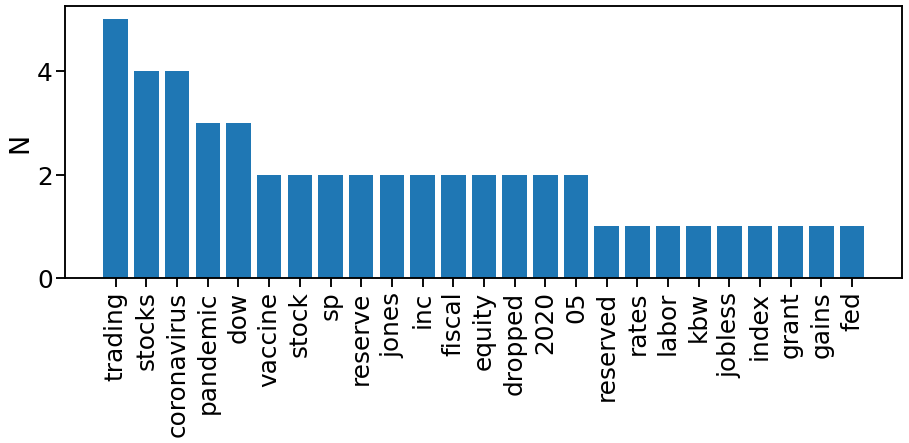

<Figure size 432x288 with 0 Axes>

In [75]:
# Create a floor of the frequency of words to remove
word_frequency_threshold = 1

# choose the number of LDA topics
num_lda_topics = 5

# do by sentences
do_sentences = 1

# loop through files
for ind, full_file_name in enumerate(full_file_names):
    
    # get extension (for testing copy and pasted html)
    fname, ext = os.path.splitext(full_file_name)

    # get path and file name
    pathstr, fname = os.path.split(full_file_name)
        
    # print file name
    print(fname)
    print(ext)
    
    if ext == '.txt':
        # get the article text as one string, remove new lines
        with open(full_file_name, 'r') as file:
            article_text = file.read().replace('\n', ' ')
            
    elif ext == '.html':
        
        # get the html as one string
        with open(full_file_name, 'r') as file:
            coverpage = file.read()

        # create soup object
        soup = BeautifulSoup(coverpage, 'html.parser')

        # get title
        headline = soup.find('h1').get_text()
        print(headline)
        print(' ')

        # get text from all <p> tags
        p_tags = soup.find_all('p')

        # get text from each p tag and strip whitespace
        p_tags_text = [tag.get_text().strip() for tag in p_tags]
        
        # filter out sentences without periods
        p_tags_text = [sentence for sentence in p_tags_text if '.' in sentence]

        # convert all p_tags_text to single article text string

        p_tags_text_1string = ''

        for p_tag_text in p_tags_text:
            p_tags_text_1string += p_tag_text

        article_text = p_tags_text_1string
#         print(article_text)
        
    # replace weird apostrophes
    article_text = article_text.replace("`","'")
    article_text = article_text.replace("’","'")
    article_text = article_text.replace("'","'")
    
    # replace long dashes with short dashes
    article_text = article_text.replace("—","-")
    
    # replace short dashes with spaces
    article_text = article_text.replace("-"," ")
    
    if do_sentences:
        # break article into sentences
        article_text = tokenize.sent_tokenize(article_text)

        article_text = [sentence.translate(sentence.maketrans('', '', string.punctuation)) for sentence in article_text]

        # following https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html#sphx-glr-auto-examples-core-run-core-concepts-py
        # Lowercase each document, split it by white space and filter out stopwords
        texts = [[word for word in document.lower().split() if word not in stop_words] 
                 for document in article_text]
        
        article_text = lemmatize(article_text,nlp)
        
        
        
    else:
        # get rid of punctuation
        article_text = article_text.translate(article_text.maketrans('', '', string.punctuation))

        # following https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html#sphx-glr-auto-examples-core-run-core-concepts-py
        # Lowercase each document, split it by white space and filter out stopwords
        texts = [[word for word in document.lower().split() if word not in stop_words] for document in [article_text]]
            
    # get corpus, dictionary, bag of words
    processed_corpus, processed_dictionary, bow_corpus = get_simple_corpus_dictionary_bow(texts,
                                                                                          word_frequency_threshold)
    
    # generate the LDA model
    lda = gensim.models.LdaModel(corpus = bow_corpus,
                                 num_topics = 5,
                                 id2word = processed_dictionary,
                                 passes = 20)

    # get the topics from the lda model
    lda_topics = lda.show_topics(formatted=False)
    
    # dictionary for topics and the probabilities associated with them
    topics_probs_dict = {}
    
    # list of unique topic names
    topics = []
    
    # loop through each list of generated topics
    for topic in lda_topics:
        
        # get the list of topics
        topic_words = topic[1]
        
        # loop through topic words and probabilities
        for topic_word, prob in topic_words:
            
            # if the word isn't already in the list of topics, add it to list of topics
            if topic_word not in topics: 
                topics.append(topic_word)
                
            # if the word is not a key in the dictionary of topics to probabilities, add it to dictionary
            if topic_word not in topics_probs_dict.keys():
                
                topics_probs_dict[topic_word] = np.array([prob])
            
            # if the word is a key in the dictionary of topics to probabilities, append probability
            else:
                topics_probs_dict[topic_word] = np.append(topics_probs_dict[topic_word],[prob])
        
    # dictionary for topic probability means
    topics_mean_probs_dict = {}

    # dictionary for topic probability std devs
    topics_std_probs_dict = {}

    # dictionary for topic frequency
    topics_frequency_dict = {}

    # loop through topics and probabilities
    for topic, prob in topics_probs_dict.items():

        # update dictionary for mean probability
        topics_mean_probs_dict[topic] = np.mean(prob)

        # update dictionary for std dev probability
        topics_std_probs_dict[topic] = np.std(prob)

        # update dictionary for topic frequency
        topics_frequency_dict[topic] =  prob.size

            
            
    # get the topic mean probs and frequencies, sorted
    topics_means, means_sorted, std_sorted, topics_freq, freq_sorted = sort_topics_mean_frequency(topics,
                                             topics_mean_probs_dict,
                                             topics_std_probs_dict,
                                             topics_frequency_dict)
        
    plt.figure(figsize=(15,5));
    plt.bar(topics_means,means_sorted,yerr=std_sorted);
    plt.ylabel('Mean probability');
    sns.set_context('talk', font_scale=1.5);
    plt.xticks(rotation=90);
    plt.show();
    plt.clf();
#     plt.savefig('./eda_figs/mean_prob_vs_topic_big_ten_resumes.png', dpi=300, bbox_inches='tight')
    
    plt.figure(figsize=(15,5));
    plt.bar(topics_freq,freq_sorted);
    plt.ylabel('N');
    # plt.xlabel('Topics')
    sns.set_context('talk', font_scale=1.5);
    plt.xticks(rotation=90);
    plt.show();
    plt.clf();
    # plt.savefig('./edafigs/frequency_vs_topic_big_ten_resumes.pdf')
    
#     print(topics)
#     print(topics_probs_dict)
#     print(' ')
        
#     if ind == 1:
#         break

In [60]:
topics_probs_dict

{'trading': array([0.11006548, 0.06669371, 0.016658  , 0.01429278], dtype=float32),
 'pandemic': array([0.11003388, 0.0856849 ], dtype=float32),
 'sp': array([0.10999722], dtype=float32),
 'labor': array([0.10999633, 0.08573774], dtype=float32),
 'stocks': array([0.06001258, 0.1103249 , 0.01665777, 0.01441793], dtype=float32),
 'coronavirus': array([0.06001126, 0.0665947 , 0.08576785], dtype=float32),
 'gains': array([0.06001116, 0.04138844], dtype=float32),
 'stock': array([0.06000005, 0.01110785, 0.07579519, 0.0166591 , 0.01449636],
       dtype=float32),
 'reserve': array([0.05996254, 0.08588068], dtype=float32),
 'fiscal': array([0.05995216, 0.06668137], dtype=float32),
 'rates': array([0.17768764], dtype=float32),
 '05': array([0.12246772], dtype=float32),
 'fed': array([0.12215985], dtype=float32),
 'equity': array([0.06668048, 0.04136822], dtype=float32),
 'grant': array([0.06666253, 0.04137893], dtype=float32),
 'kbw': array([0.06666251, 0.0413789 ], dtype=float32),
 '2020': ar

In [42]:
from text_processing_functions import process_all_articles, remove_stopwords

article_processed_test = process_all_articles(article_text)
article_test_2 = remove_stopwords(article_processed_test,stop_words)
# print(article_text)
# print(' ')
# print(article_processed_test)
# print(' ')
# print(article_test_2)

processed_corpus, processed_dictionary, bow_corpus = get_simple_corpus_dictionary_bow(article_test_2,
                                                                                          word_frequency_threshold)

processed_corpus, processed_dictionary, bow_corpus = get_simple_corpus_dictionary_bow(texts, word_frequency_threshold)


In [58]:
for topic in lda_topics:
    print(topic[1])

[('stocks', 0.20022574), ('labor', 0.0573581), ('sp', 0.057250205), ('dropped', 0.05722411), ('coronavirus', 0.057182007), ('jones', 0.0571503), ('jobless', 0.057119813), ('pandemic', 0.057119448), ('05', 0.05708975), ('dow', 0.057034053)]
[('dow', 0.12967487), ('2020', 0.12964301), ('labor', 0.07076046), ('jones', 0.070640706), ('jobless', 0.07063217), ('reserved', 0.07057466), ('inc', 0.07048918), ('reserve', 0.07047299), ('pandemic', 0.07038476), ('stock', 0.070355184)]
[('trading', 0.12812345), ('reserve', 0.088080354), ('inc', 0.08807014), ('gains', 0.08804335), ('index', 0.0879057), ('grant', 0.04803761), ('kbw', 0.048037577), ('equity', 0.048020896), ('dropped', 0.04800828), ('jones', 0.047993667)]
[('vaccine', 0.14561245), ('rates', 0.14542316), ('05', 0.100089446), ('coronavirus', 0.10000119), ('fed', 0.09997775), ('equity', 0.054535806), ('kbw', 0.054515973), ('grant', 0.05451595), ('trading', 0.05446475), ('fiscal', 0.054362416)]
[('stock', 0.15079293), ('pandemic', 0.150192

In [16]:
str(article_text)

'httpswwwwsjcomarticlesglobal stock markets dow update 9 17 2020 11600334220US stocks fell Thursday hurt by weakness in the labor market as uncertainty over the coronavirus pandemic continues to weigh on hiringThe SP 500 dropped 08 to 3357 The Nasdaq Composite declined 13 to 10910 pushing the tech heavy index further into negative territory for the month The Dow Jones Industrial Average snapped a four day winning streak closing down 05 or 130 points to 27902The declines on Thursday included big technology companies but were broad based after stocks had rallied over the past several months Investors have attributed part of those gains to action from the Federal Reserve in the early days of the pandemicNow they are waiting for clues on what will come next either on the economy or action from the government“Weve had so many risk on moves over the past three or four months that I think its a little bit of an indictment on where we stand” said RJ Grant  director of equity trading at KBW Inc